(3, 192, 192, 3)
0 255
(3, 6, 192, 192)
0.0 1.0
mask.shape:(6, 192, 192)
mask.shape:(6, 192, 192)
mask.shape:(6, 192, 192)
nrow: 3


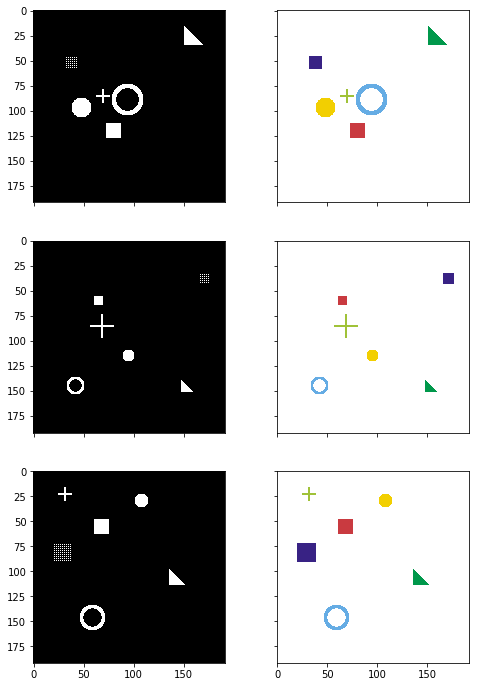

In [4]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os,sys
import matplotlib.pyplot as plt
import numpy as np
import helper
import simulation

# Generate some random images
input_images, target_masks = simulation.generate_random_data(192, 192, count=3)

for x in [input_images, target_masks]:
    print(x.shape)
    print(x.min(), x.max())

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in input_images]


# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in target_masks]

# Left: Input image, Right: Target mask
helper.plot_side_by_side([input_images_rgb, target_masks_rgb])

In [20]:
a=1
print(f'123{a}')

1231


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
(112, 112)
masks shape: (7, 112, 112)
PlasmaMembrane
Cytoskeleton
mask.shape:(7, 112, 112)
(1, 112, 112, 3)


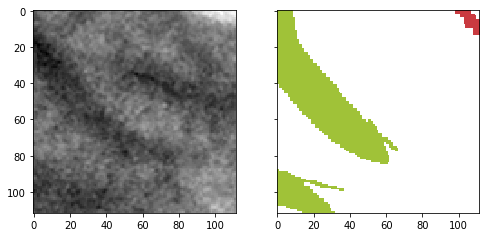

In [83]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import os,sys
import matplotlib.pyplot as plt
import numpy as np
import helper
import simulation
import PIL
import os.path as osp
from PIL import Image

def load_pil(img):
    img = Image.open(img)
    return np.array(img)

category = ['PlasmaMembrane','NuclearMembrane','MitochondriaDark','MitochondriaLight','Desmosome','Cytoskeleton','LipidDroplet']

def generate_mask(dataset,name,shape=112):
    dataset = osp.join(dataset,'Mask')
    organelles = os.listdir(dataset)
#     print(organelles)
    shapes = (shape,shape)
    masks = np.zeros((len(category),*shapes)).astype(np.float32)
    print(f'masks shape: {masks.shape}')
    for i in range(len(category)):
        if category[i] in organelles:
            mask = load_pil(osp.join(dataset,category[i],name))
#             print(np.sum(mask))
#             if np.sum(mask)!=0:
#                 print(category[i])
#             mask[mask==1]=255
            masks[i] = mask
            
#     print(f'mask after gen: {masks.shape}')
    return masks
            
                
            
    
# Generate some random images
# input_images, target_masks = simulation.generate_random_data(192, 192, count=3)
dataset = 'D:/repos/UTexas/112_dragonfly_training_dataset/112_dataset/train_data_T4R/CL_T4R_180807_01'

original = '18_42.png'

input_images = load_pil(osp.join(dataset,'Original',original))

print(input_images.shape)
target_masks = generate_mask(dataset,original)


# for x in [input_images, target_masks]:
#     print(x.shape)
#     print(x.min(), x.max())

# Change channel-order and make 3 channels for matplot
input_images_rgb = [x.astype(np.uint8) for x in input_images]


# Map each channel (i.e. class) to each color
# target_masks_rgb = helper.masks_to_colorimg(x) for x in target_masks

# Left: Input image, Right: Target mask
# helper.plot_side_by_side([input_images_rgb, target_masks_rgb])
# Image.fromarray(input_images)
target_masks_rgb = [helper.masks_to_colorimg(target_masks)]
print((np.array(target_masks_rgb)).shape)
img_array = np.array(target_masks_rgb)
# helper.plot_img_array(img_array,ncol=1)

f, plot = plt.subplots(1, 2, sharex='all', sharey='all', figsize=(2 * 4, 2 * 4))
plot[1].imshow(img_array[0])
plot[0].imshow(input_images, cmap='gray')


In [78]:
# np.sum(target_masks)





In [5]:
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, datasets, models

class SimDataset(Dataset):
    def __init__(self, count, transform=None):
        self.input_images, self.target_masks = simulation.generate_random_data(112, 112, count=count)        
        self.transform = transform
    
    def __len__(self):
        return len(self.input_images)
    
    def __getitem__(self, idx):        
        image = self.input_images[idx]
        mask = self.target_masks[idx]
        if self.transform:
            image = self.transform(image)
        
        return [image, mask]

# use same transform for train/val for this example
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # imagenet
])

train_set = SimDataset(2000, transform=trans)
val_set = SimDataset(200, transform=trans)

image_datasets = {
    'train': train_set, 'val': val_set
}

batch_size = 25

dataloaders = {
    'train': DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=0),
    'val': DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=0)
}

dataset_sizes = {
    x: len(image_datasets[x]) for x in image_datasets.keys()
}

dataset_sizes

{'train': 2000, 'val': 200}

torch.Size([25, 3, 112, 112]) torch.Size([25, 6, 112, 112])
-2.117904 2.64 -1.8975176 0.6337044
0.0 1.0 0.0038972152 0.06230594


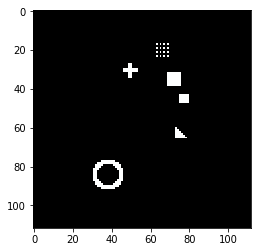

In [6]:
import torchvision.utils

def reverse_transform(inp):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    inp = (inp * 255).astype(np.uint8)
    
    return inp

# Get a batch of training data
inputs, masks = next(iter(dataloaders['train']))

print(inputs.shape, masks.shape)
for x in [inputs.numpy(), masks.numpy()]:
    print(x.min(), x.max(), x.mean(), x.std())

plt.imshow(reverse_transform(inputs[20]))

In [42]:
from torchvision import models

base_model = models.resnet18(pretrained=False)
res18  = list(models.resnet18(pretrained=False).children())
len(res18)

10

In [31]:
base_model = models.resnet50(pretrained=False)


res50 = list(base_model.children())
# print(res50)
res50[8:]

[AdaptiveAvgPool2d(output_size=(1, 1)),
 Linear(in_features=2048, out_features=1000, bias=True)]

In [21]:
# check keras-like model summary using torchsummary
import torch
from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
base_model = base_model.to(device)

summary(base_model, input_size=(3, 112, 112))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 56, 56]           9,408
       BatchNorm2d-2           [-1, 64, 56, 56]             128
              ReLU-3           [-1, 64, 56, 56]               0
         MaxPool2d-4           [-1, 64, 28, 28]               0
            Conv2d-5           [-1, 64, 28, 28]          36,864
       BatchNorm2d-6           [-1, 64, 28, 28]             128
              ReLU-7           [-1, 64, 28, 28]               0
            Conv2d-8           [-1, 64, 28, 28]          36,864
       BatchNorm2d-9           [-1, 64, 28, 28]             128
             ReLU-10           [-1, 64, 28, 28]               0
       BasicBlock-11           [-1, 64, 28, 28]               0
           Conv2d-12           [-1, 64, 28, 28]          36,864
      BatchNorm2d-13           [-1, 64, 28, 28]             128
             ReLU-14           [-1, 64,

In [34]:
import torch
import torch.nn as nn

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class ResNetUNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet18(pretrained=False)
        
        self.base_layers = list(self.base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 64, x.H/4, x.W/4)        
        self.layer1_1x1 = convrelu(64, 64, 1, 0)       
        self.layer2 = self.base_layers[5]  # size=(N, 128, x.H/8, x.W/8)        
        self.layer2_1x1 = convrelu(128, 128, 1, 0)  
        self.layer3 = self.base_layers[6]  # size=(N, 256, x.H/16, x.W/16)        
        self.layer3_1x1 = convrelu(256, 256, 1, 0)  
        self.layer4 = self.base_layers[7]  # size=(N, 512, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(512, 512, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(256 + 512, 512, 3, 1)
        self.conv_up2 = convrelu(128 + 512, 256, 3, 1)
        self.conv_up1 = convrelu(64 + 256, 256, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 128, 3, 1)
        
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(input)            
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        out = self.conv_last(x)        
        
        return out

In [39]:
import torch
import torch.nn as nn

def convrelu(in_channels, out_channels, kernel, padding):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel, padding=padding),
        nn.ReLU(inplace=True),
    )

class ResNet50UNet(nn.Module):

    def __init__(self, n_class):
        super().__init__()
        
        self.base_model = models.resnet50(pretrained=False)
        
        self.base_layers = list(self.base_model.children())                
        
        self.layer0 = nn.Sequential(*self.base_layers[:3]) # size=(N, 64, x.H/2, x.W/2)
        self.layer0_1x1 = convrelu(64, 64, 1, 0)
        self.layer1 = nn.Sequential(*self.base_layers[3:5]) # size=(N, 256, x.H/4, x.W/4)        
        self.layer1_1x1 = convrelu(256, 256, 1, 0)       
        self.layer2 = self.base_layers[5]  # size=(N, 512, x.H/8, x.W/8)        
        self.layer2_1x1 = convrelu(512, 512, 1, 0)  
        self.layer3 = self.base_layers[6]  # size=(N, 1024, x.H/16, x.W/16)        
        self.layer3_1x1 = convrelu(1024, 1024, 1, 0)  
        self.layer4 = self.base_layers[7]  # size=(N, 2048, x.H/32, x.W/32)
        self.layer4_1x1 = convrelu(2048, 2048, 1, 0)  
        
        self.upsample = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        
        self.conv_up3 = convrelu(1024 + 2048, 2048, 3, 1)
        self.conv_up2 = convrelu(512 + 1024, 1024, 3, 1)
        self.conv_up1 = convrelu(256 + 1024, 512, 3, 1)
        self.conv_up0 = convrelu(64 + 256, 256, 3, 1)
        
        self.conv_original_size0 = convrelu(3, 64, 3, 1)
        self.conv_original_size1 = convrelu(64, 64, 3, 1)
        self.conv_original_size2 = convrelu(64 + 128, 64, 3, 1)
        
        self.conv_last = nn.Conv2d(64, n_class, 1)
        
    def forward(self, input):
        x_original = self.conv_original_size0(input)
        x_original = self.conv_original_size1(x_original)
        
        layer0 = self.layer0(input)            
        layer1 = self.layer1(layer0)
        layer2 = self.layer2(layer1)
        layer3 = self.layer3(layer2)        
        layer4 = self.layer4(layer3)
        
        layer4 = self.layer4_1x1(layer4)
        x = self.upsample(layer4)
        layer3 = self.layer3_1x1(layer3)
        x = torch.cat([x, layer3], dim=1)
        x = self.conv_up3(x)
 
        x = self.upsample(x)
        layer2 = self.layer2_1x1(layer2)
        x = torch.cat([x, layer2], dim=1)
        x = self.conv_up2(x)

        x = self.upsample(x)
        layer1 = self.layer1_1x1(layer1)
        x = torch.cat([x, layer1], dim=1)
        x = self.conv_up1(x)

        x = self.upsample(x)
        layer0 = self.layer0_1x1(layer0)
        x = torch.cat([x, layer0], dim=1)
        x = self.conv_up0(x)
        
        x = self.upsample(x)
        x = torch.cat([x, x_original], dim=1)
        x = self.conv_original_size2(x)        
        
        out = self.conv_last(x)        
        
        return out

In [43]:

from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNet50UNet(7)
model = model.to(device)

summary(model, input_size=(3, 112, 112))

RuntimeError: invalid argument 0: Sizes of tensors must match except in dimension 1. Got 8 and 7 in dimension 2 at ..\aten\src\TH/generic/THTensor.cpp:711

In [23]:
# check keras-like model summary using torchsummary

from torchsummary import summary

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ResNetUNet(6)
model = model.to(device)

summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
            Conv2d-5         [-1, 64, 112, 112]           9,408
       BatchNorm2d-6         [-1, 64, 112, 112]             128
              ReLU-7         [-1, 64, 112, 112]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]          36,864
      BatchNorm2d-10           [-1, 64, 56, 56]             128
             ReLU-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [94]:
from collections import defaultdict
import torch.nn.functional as F
import torch
from loss import dice_loss

def calc_loss(pred, target, metrics, bce_weight=0.5):
    bce = F.binary_cross_entropy_with_logits(pred, target)
        
    pred = torch.sigmoid(pred)
    dice = dice_loss(pred, target)
    
    loss = bce * bce_weight + dice * (1 - bce_weight)
    
    metrics['bce'] += bce.data.cpu().numpy() * target.size(0)
    metrics['dice'] += dice.data.cpu().numpy() * target.size(0)
    metrics['loss'] += loss.data.cpu().numpy() * target.size(0)
    
    return loss

def print_metrics(metrics, epoch_samples, phase):    
    outputs = []
    for k in metrics.keys():
        outputs.append("{}: {:4f}".format(k, metrics[k] / epoch_samples))
        
    print("{}: {}".format(phase, ", ".join(outputs)))    

def train_model(model, optimizer, scheduler, num_epochs=25):
    best_model_wts = copy.deepcopy(model.state_dict())
    best_loss = 1e10

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)
        
        since = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                scheduler.step()
                for param_group in optimizer.param_groups:
                    print("LR", param_group['lr'])
                    
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            metrics = defaultdict(float)
            epoch_samples = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)             

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = calc_loss(outputs, labels, metrics)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                epoch_samples += inputs.size(0)

            print_metrics(metrics, epoch_samples, phase)
            epoch_loss = metrics['loss'] / epoch_samples

            # deep copy the model
            if phase == 'val' and epoch_loss < best_loss:
                print("saving best model")
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())

        time_elapsed = time.time() - since
        print('{:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
            
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [95]:
import torch
import torch.optim as optim
from torch.optim import lr_scheduler
import time
import copy

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

num_class = 6

model = ResNetUNet(num_class).to(device)

# freeze backbone layers
# Comment out to finetune further
for l in model.base_layers:
    for param in l.parameters():
        param.requires_grad = False

optimizer_ft = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-4)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.1)        
        
model = train_model(model, optimizer_ft, exp_lr_scheduler, num_epochs=15)

cpu
Epoch 0/14
----------
LR 0.0001


KeyboardInterrupt: 

(3, 6, 192, 192)


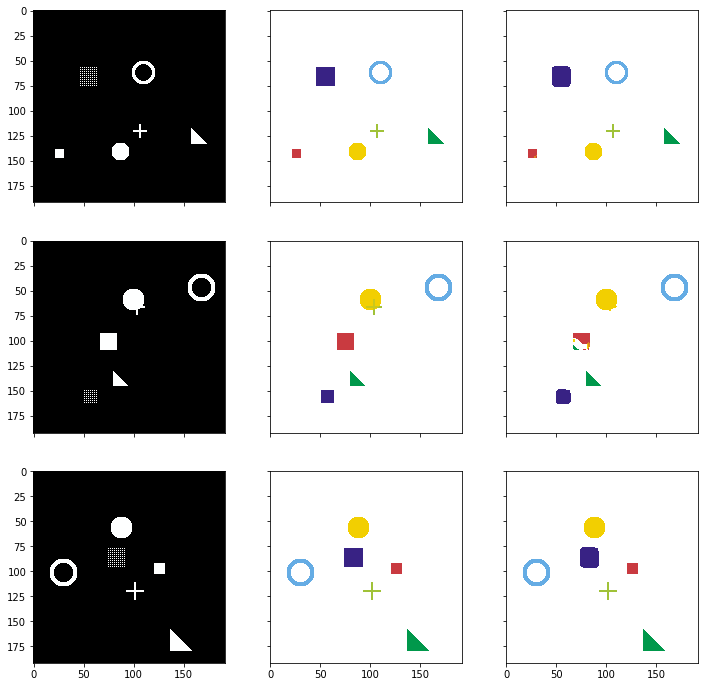

In [10]:
#### prediction

import math

model.eval()   # Set model to evaluate mode

test_dataset = SimDataset(3, transform = trans)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, num_workers=0)
        
inputs, labels = next(iter(test_loader))
inputs = inputs.to(device)
labels = labels.to(device)

pred = model(inputs)
pred = torch.sigmoid(pred)
pred = pred.data.cpu().numpy()
print(pred.shape)

# Change channel-order and make 3 channels for matplot
input_images_rgb = [reverse_transform(x) for x in inputs.cpu()]

# Map each channel (i.e. class) to each color
target_masks_rgb = [helper.masks_to_colorimg(x) for x in labels.cpu().numpy()]
pred_rgb = [helper.masks_to_colorimg(x) for x in pred]

helper.plot_side_by_side([input_images_rgb, target_masks_rgb, pred_rgb])